# test roll out predictions with GP

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from link_bot_gaussian_process import link_bot_gp, data_reformatting
from link_bot_pycommon import link_bot_pycommon, link_bot_sdf_utils
import tensorflow as tf
from IPython.display import HTML
import warnings
from matplotlib import animation
import gpflow as gpf
import h5py

tf.logging.set_verbosity(tf.logging.ERROR)
np.set_printoptions(suppress=True, precision=4, linewidth=200)
plt.style.use("slides")
plt.style.use("slides")

In [3]:
sdf, _, _, _ = link_bot_sdf_utils.load_sdf("/home/pmitrano/catkin_ws/src/link_bot/link_bot_data/data/sdfs/empty_sdf.npz")

In [11]:
gp_model_dir = '/home/pmitrano/catkin_ws/src/link_bot/link_bot_gaussian_process/log_data/separate_independent/July_11_11-27-20__1d6becf268__gpf/'

gpf.reset_default_graph_and_session()
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=False, per_process_gpu_memory_fraction=0.05))
gpf.reset_default_session(config=config)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=h5py.h5py_warnings.H5pyDeprecationWarning)
    fwd_gp_model = link_bot_gp.LinkBotGP()
    fwd_gp_model.load(os.path.join(gp_model_dir, 'fwd_model'))
    
    inv_gp_model = link_bot_gp.LinkBotGP()
    inv_gp_model.load(os.path.join(gp_model_dir, 'inv_model'))

Loading model from /home/pmitrano/catkin_ws/src/link_bot/link_bot_gaussian_process/log_data/separate_independent/July_11_11-27-20__1d6becf268__gpf/fwd_model
Loading model from /home/pmitrano/catkin_ws/src/link_bot/link_bot_gaussian_process/log_data/separate_independent/July_11_11-27-20__1d6becf268__gpf/inv_model


In [12]:
initial_config = np.array([[0.5, 0.5, 0.5, 0, 0, 0]])
steps = 150
vx = -0.3
vy = 0.3
controls =  np.tile([vx,vy], [steps, 1])
durations = np.ones(steps, dtype=np.int)
prediction, variances = link_bot_gp.predict(fwd_gp_model, initial_config, controls, durations)
anim = link_bot_gp.animate_predict(prediction, sdf, arena_size=5, linewidth=2)
plt.close()
HTML(anim.to_jshtml())

In [10]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anim.save('new_gp_prediction.mp4', writer=writer)

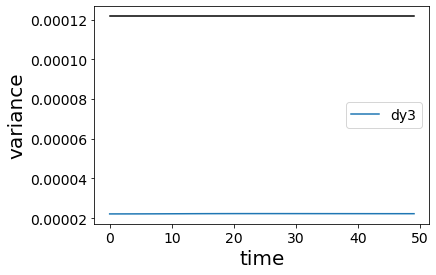

In [34]:
plt.figure()
plt.plot(variances[:, 0], label='dx1')
plt.plot(variances[:, 1], label='dy1')
plt.plot(variances[:, 2], label='dx2')
plt.plot(variances[:, 3], label='dy2')
plt.plot(variances[:, 4], label='dx3')
plt.plot(variances[:, 5], label='dy3')
plt.plot(np.linalg.norm(controls * 1e-4, axis=1), color='k')
plt.xlabel("time")
plt.ylabel("variance")
plt.legend();